In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import zscore, percentileofscore
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [59]:
print("="*80)
print("ALGERIA ECONOMIC COMPARISON ANALYSIS")
print("="*80)

df = pd.read_csv('../../data/preprocessed/economic_indicators_dataset.csv')
print(f"\n✅ Loaded: {df.shape[0]} countries, {df.shape[1]} indicators")

if 'Algeria' not in df['Country'].values:
    print("❌ ERROR: Algeria not found!")
    exit()

# Preprocessing
countries = df['Country'].copy()
numeric_df = df.select_dtypes(include=[np.number])
numeric_df_filled = numeric_df.fillna(numeric_df.median())
df_processed = pd.concat([countries, numeric_df_filled], axis=1)

algeria_data = df_processed[df_processed['Country'] == 'Algeria'].iloc[0]
algeria_numeric = algeria_data.drop('Country')

print(f"🇩🇿 Algeria data: {len(algeria_numeric)} indicators")

ALGERIA ECONOMIC COMPARISON ANALYSIS

✅ Loaded: 266 countries, 84 indicators
🇩🇿 Algeria data: 83 indicators


# TECHNIQUE 1: PERCENTILE RANKING


🏆 TOP 10 STRONGEST:
                                                                                               Indicator  Percentile
                                                                 Structure_Exports_Fuels_% of total_2015   99.624060
Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2021   96.992481
                 Unemployment_Unemployment, female (% of female labor force) (modeled ILO estimate)_2021   95.488722
Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2015   95.112782
                                       GDP_Growth_Manufacturing_average annual real growth (%)_2020-2024   93.421053
                                                                  Structure_Value_Industry_% of GDP_2024   91.165414
    Unemployment_Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)_2021   89.849624
                                         GD

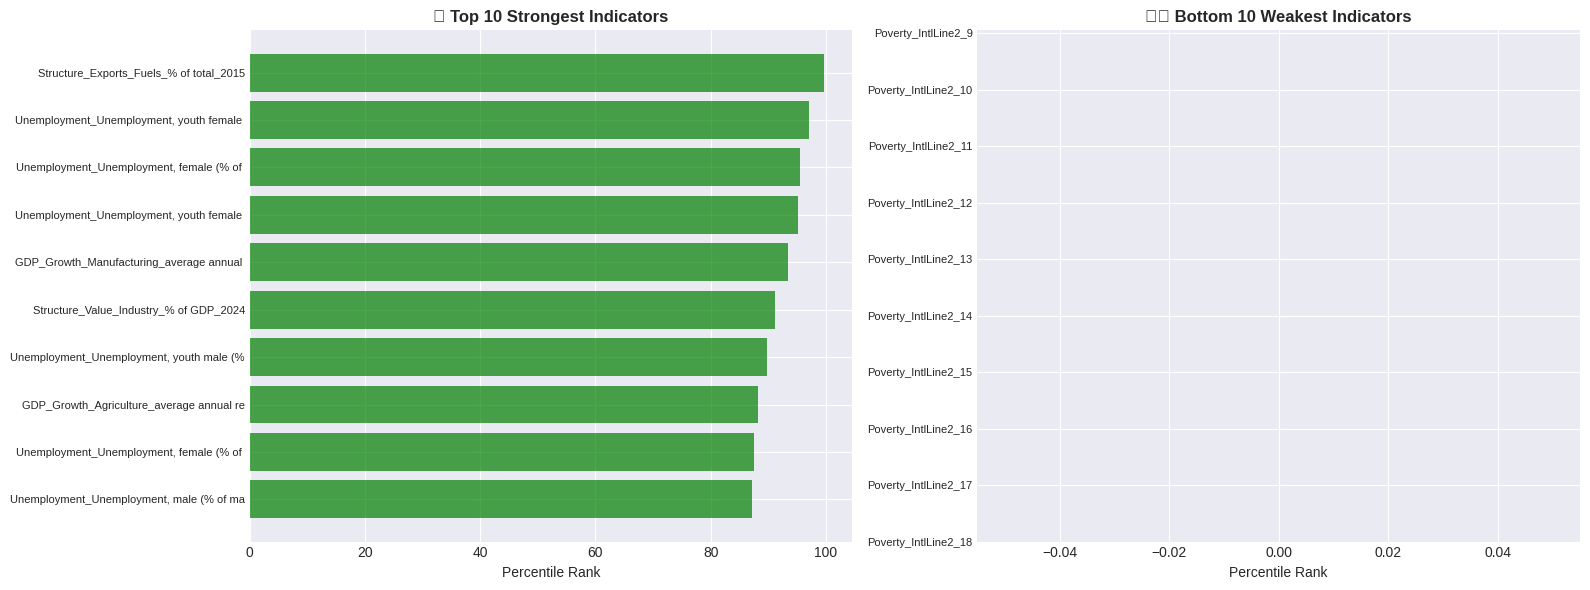

In [60]:
percentile_ranks = {col: percentileofscore(numeric_df_filled[col], algeria_numeric[col]) 
                    for col in numeric_df_filled.columns}
percentile_df = pd.DataFrame(list(percentile_ranks.items()), 
                              columns=['Indicator', 'Percentile']).sort_values('Percentile', ascending=False)

print(f"\n🏆 TOP 10 STRONGEST:")
print(percentile_df.head(10).to_string(index=False))
print(f"\n⚠️ BOTTOM 10 WEAKEST:")
print(percentile_df.tail(10).to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
top_10 = percentile_df.head(10)
ax1.barh(range(len(top_10)), top_10['Percentile'], color='green', alpha=0.7)
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels([ind[:40] for ind in top_10['Indicator']], fontsize=8)
ax1.set_xlabel('Percentile Rank')
ax1.set_title('🏆 Top 10 Strongest Indicators', fontweight='bold')
ax1.invert_yaxis()

bottom_10 = percentile_df.tail(10)
ax2.barh(range(len(bottom_10)), bottom_10['Percentile'], color='red', alpha=0.7)
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels([ind[:40] for ind in bottom_10['Indicator']], fontsize=8)
ax2.set_xlabel('Percentile Rank')
ax2.set_title('⚠️ Bottom 10 Weakest Indicators', fontweight='bold')
ax2.invert_yaxis()
plt.tight_layout()

# TECHNIQUE 2: EUCLIDEAN DISTANCE


🌍 TOP 15 MOST SIMILAR:
                                                                  Country  Distance
                                                       Iran, Islamic Rep.  5.362486
                                                               Arab World  6.448418
                        Middle East, North Africa, Afghanistan & Pakistan  6.602646
                                                    Virgin Islands (U.S.)  7.004451
                                                                    Gabon  7.021144
                                                             Small states  7.158536
                                                                 Colombia  7.255682
                                                   Caribbean small states  7.259048
           Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)  7.268419
Middle East, North Africa, Afghanistan & Pakistan (excluding high income)  7.276155
                                                    

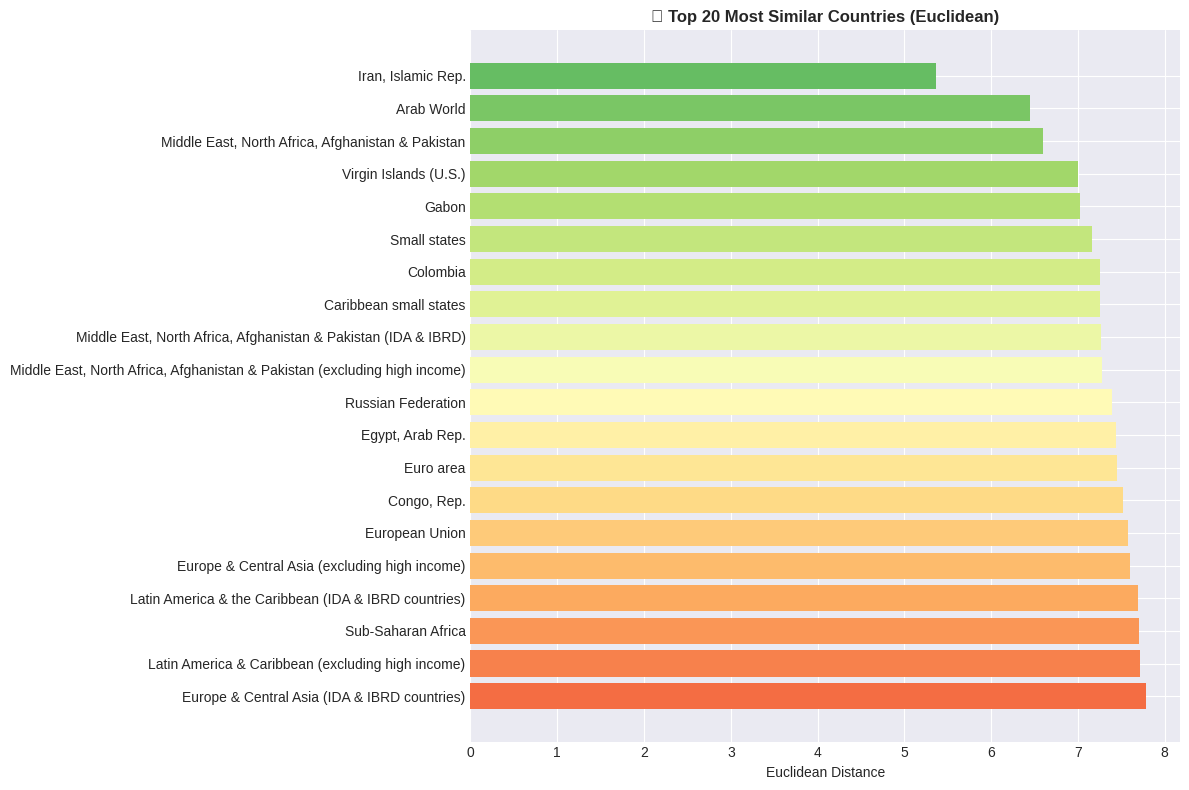

In [77]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df_filled)

# Check for and handle NaN/Inf values
if np.any(np.isnan(scaled_data)) or np.any(np.isinf(scaled_data)):
    print("Warning: NaN or Inf values found in scaled data. Replacing with 0.")
    scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

algeria_idx = df_processed[df_processed['Country'] == 'Algeria'].index[0]
algeria_scaled = scaled_data[algeria_idx]

euclidean_distances = {}
for idx in range(len(countries)):
    if countries.iloc[idx] != 'Algeria':
        try:
            dist = euclidean(algeria_scaled, scaled_data[idx])
            euclidean_distances[countries.iloc[idx]] = dist
        except ValueError as e:
            print(f"Skipping {countries.iloc[idx]} due to error: {e}")
            continue

euclidean_df = pd.DataFrame(list(euclidean_distances.items()), 
                           columns=['Country', 'Distance']).sort_values('Distance')

print(f"\n🌍 TOP 15 MOST SIMILAR:")
print(euclidean_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
top_20 = euclidean_df.head(20)
ax.barh(range(len(top_20)), top_20['Distance'], color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 20)))
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Country'], fontsize=10)
ax.set_xlabel('Euclidean Distance')
ax.set_title('🌍 Top 20 Most Similar Countries (Euclidean)', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()

# TECHNIQUE 3: COSINE SIMILARITY

In [74]:
from scipy.spatial.distance import cosine as cosine_distance

# Re-standardize with proper NaN handling
scaler = StandardScaler()
# Fill NaN before scaling
numeric_clean = numeric_df_filled.fillna(numeric_df_filled.median())
scaled_data = scaler.fit_transform(numeric_clean)

# Get Algeria's index and scaled data
algeria_idx = df_processed[df_processed['Country'] == 'Algeria'].index[0]
algeria_scaled = scaled_data[algeria_idx]

print(f"Debug: Algeria scaled shape: {algeria_scaled.shape}")
print(f"Debug: Has NaN in Algeria: {np.any(np.isnan(algeria_scaled))}")
print(f"Debug: Has Inf in Algeria: {np.any(np.isinf(algeria_scaled))}")

cosine_similarities = {}
for idx in range(len(countries)):
    if countries.iloc[idx] != 'Algeria':
        country_vec = scaled_data[idx]
        
        # Simple check - if both vectors are valid
        if (not np.any(np.isnan(algeria_scaled)) and 
            not np.any(np.isnan(country_vec)) and
            not np.any(np.isinf(algeria_scaled)) and 
            not np.any(np.isinf(country_vec))):
            try:
                similarity = 1 - cosine_distance(algeria_scaled, country_vec)
                if not np.isnan(similarity):
                    cosine_similarities[countries.iloc[idx]] = similarity
            except:
                pass

print(f"Debug: Found {len(cosine_similarities)} valid countries")

cosine_df = pd.DataFrame(list(cosine_similarities.items()), 
                         columns=['Country', 'Similarity']).sort_values('Similarity', ascending=False)

print(f"\n🔍 TOP 15 MOST SIMILAR:")
print(cosine_df.head(15).to_string(index=False))

if len(cosine_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = cosine_df.head(20)
    ax.barh(range(len(top_20)), top_20['Similarity'], color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, 20)))
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('Cosine Similarity')
    ax.set_title('🔍 Top 20 Most Similar Patterns (Cosine)', fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
else:
    print("⚠️ Warning: No valid cosine similarities calculated")

Debug: Algeria scaled shape: (83,)
Debug: Has NaN in Algeria: True
Debug: Has Inf in Algeria: False
Debug: Found 0 valid countries

🔍 TOP 15 MOST SIMILAR:
Empty DataFrame
Columns: [Country, Similarity]
Index: []
⚠️ Warning: No valid cosine similarities calculated


# TECHNIQUE 4: Z-SCORE PROFILING


🚀 EXCEPTIONAL HIGH (>2 SD): 3
Structure_Exports_Fuels_% of total_2015                                                                     4.290183
Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2021    2.359674
Unemployment_Unemployment, female (% of female labor force) (modeled ILO estimate)_2021                     2.163355
dtype: float64

⚠️ EXCEPTIONAL LOW (<-2 SD): 1
Poverty_IntlLine1_International poverty lines_Population below $3.00 a day_%   -2.256487
dtype: float64


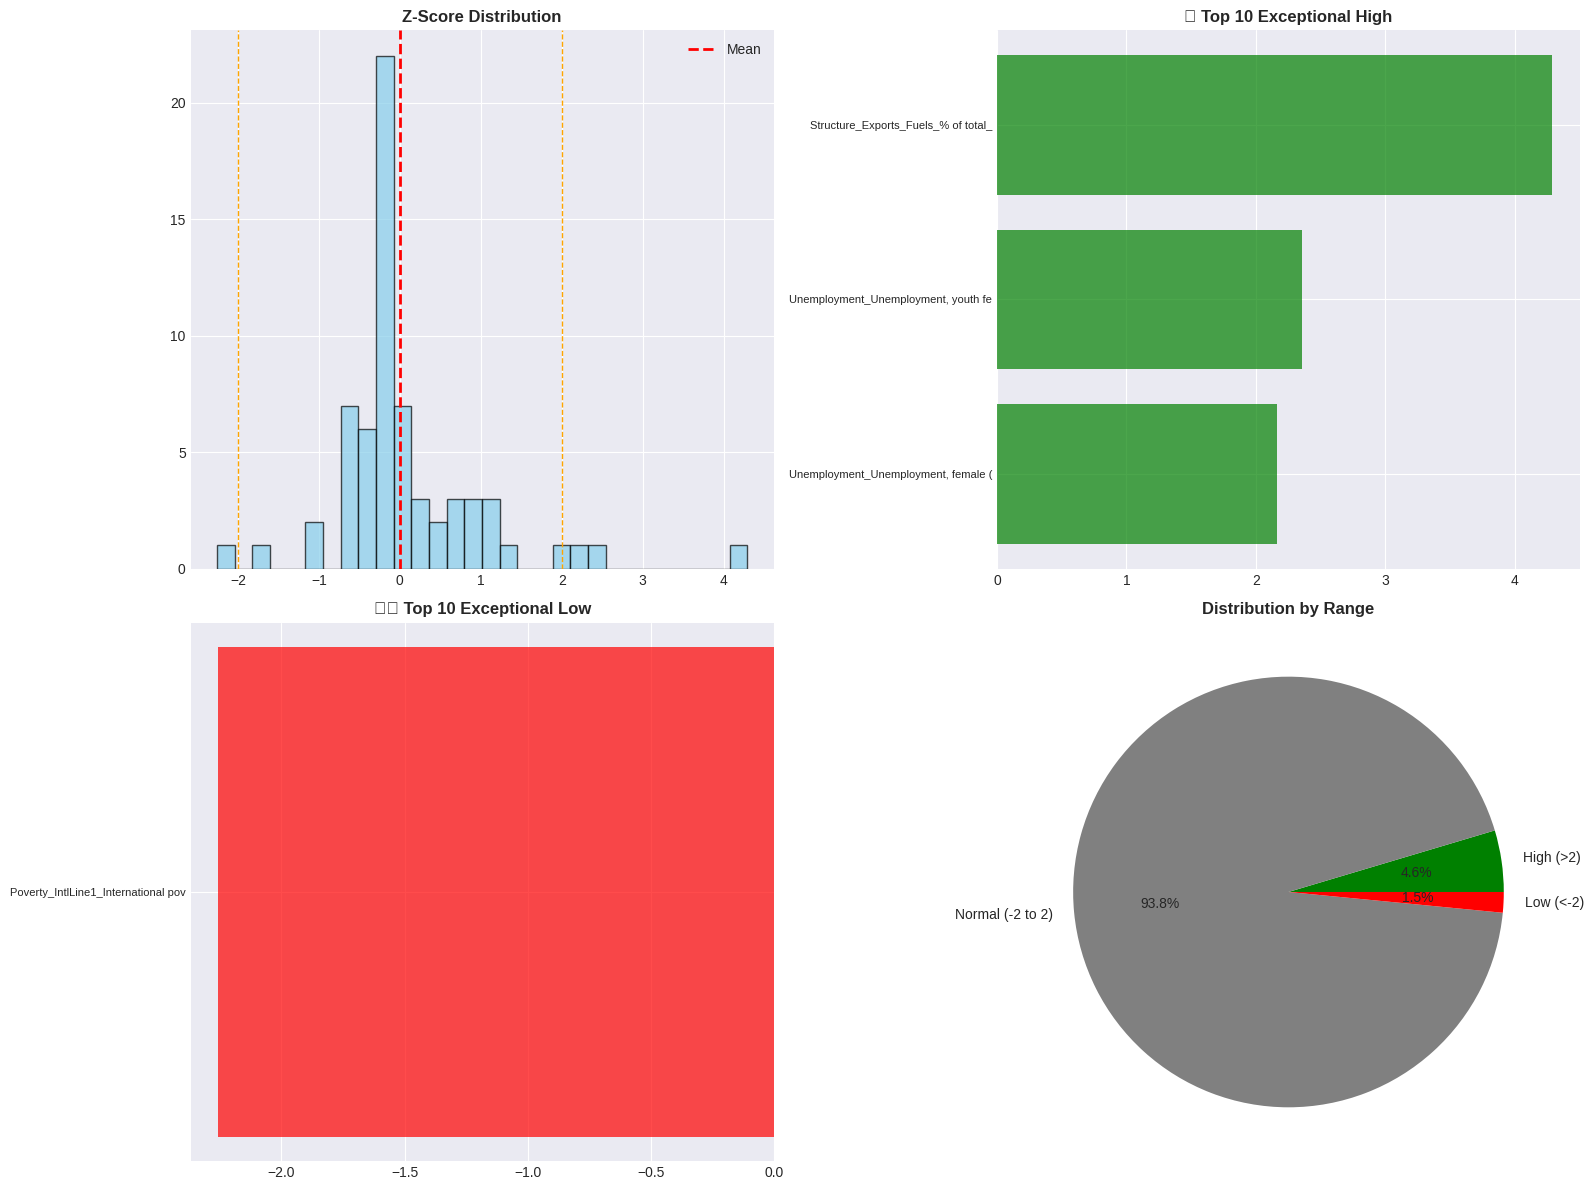

In [64]:

z_scores = zscore(numeric_df_filled, nan_policy='omit')
algeria_z = z_scores[algeria_idx]

exceptional_high = pd.Series(algeria_z[algeria_z > 2], index=numeric_df_filled.columns[algeria_z > 2])
exceptional_low = pd.Series(algeria_z[algeria_z < -2], index=numeric_df_filled.columns[algeria_z < -2])

print(f"\n🚀 EXCEPTIONAL HIGH (>2 SD): {len(exceptional_high)}")
if len(exceptional_high) > 0:
    print(exceptional_high.sort_values(ascending=False).head(10))

print(f"\n⚠️ EXCEPTIONAL LOW (<-2 SD): {len(exceptional_low)}")
if len(exceptional_low) > 0:
    print(exceptional_low.sort_values().head(10))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].hist(algeria_z, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(x=2, color='orange', linestyle='--', linewidth=1)
axes[0, 0].axvline(x=-2, color='orange', linestyle='--', linewidth=1)
axes[0, 0].set_title('Z-Score Distribution', fontweight='bold')
axes[0, 0].legend()

if len(exceptional_high) > 0:
    top = exceptional_high.sort_values(ascending=False).head(10)
    axes[0, 1].barh(range(len(top)), top.values, color='green', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top)))
    axes[0, 1].set_yticklabels([i[:35] for i in top.index], fontsize=8)
    axes[0, 1].set_title('🚀 Top 10 Exceptional High', fontweight='bold')
    axes[0, 1].invert_yaxis()

if len(exceptional_low) > 0:
    bottom = exceptional_low.sort_values().head(10)
    axes[1, 0].barh(range(len(bottom)), bottom.values, color='red', alpha=0.7)
    axes[1, 0].set_yticks(range(len(bottom)))
    axes[1, 0].set_yticklabels([i[:35] for i in bottom.index], fontsize=8)
    axes[1, 0].set_title('⚠️ Top 10 Exceptional Low', fontweight='bold')
    axes[1, 0].invert_yaxis()

categories = ['High (>2)', 'Normal (-2 to 2)', 'Low (<-2)']
counts = [len(exceptional_high), len(algeria_z[(algeria_z >= -2) & (algeria_z <= 2)]), len(exceptional_low)]
axes[1, 1].pie(counts, labels=categories, autopct='%1.1f%%', colors=['green', 'gray', 'red'])
axes[1, 1].set_title('Distribution by Range', fontweight='bold')
plt.tight_layout()

# TECHNIQUE 5: PEER GROUP IDENTIFICATION


👥 FOUND 47 PEER COUNTRIES:
                                          Country  Match_Ratio
                               Iran, Islamic Rep.         1.00
                                         Suriname         1.00
                                          Bahrain         0.75
                                        Indonesia         0.75
                                          Lesotho         0.75
                                         Eswatini         0.75
                                         Mongolia         0.75
Middle East, North Africa, Afghanistan & Pakistan         0.75
                                         Paraguay         0.75
                                         Viet Nam         0.75
                                             Peru         0.75
                                       Bangladesh         0.50
                                          Belarus         0.50
                                          Burundi         0.50
                           

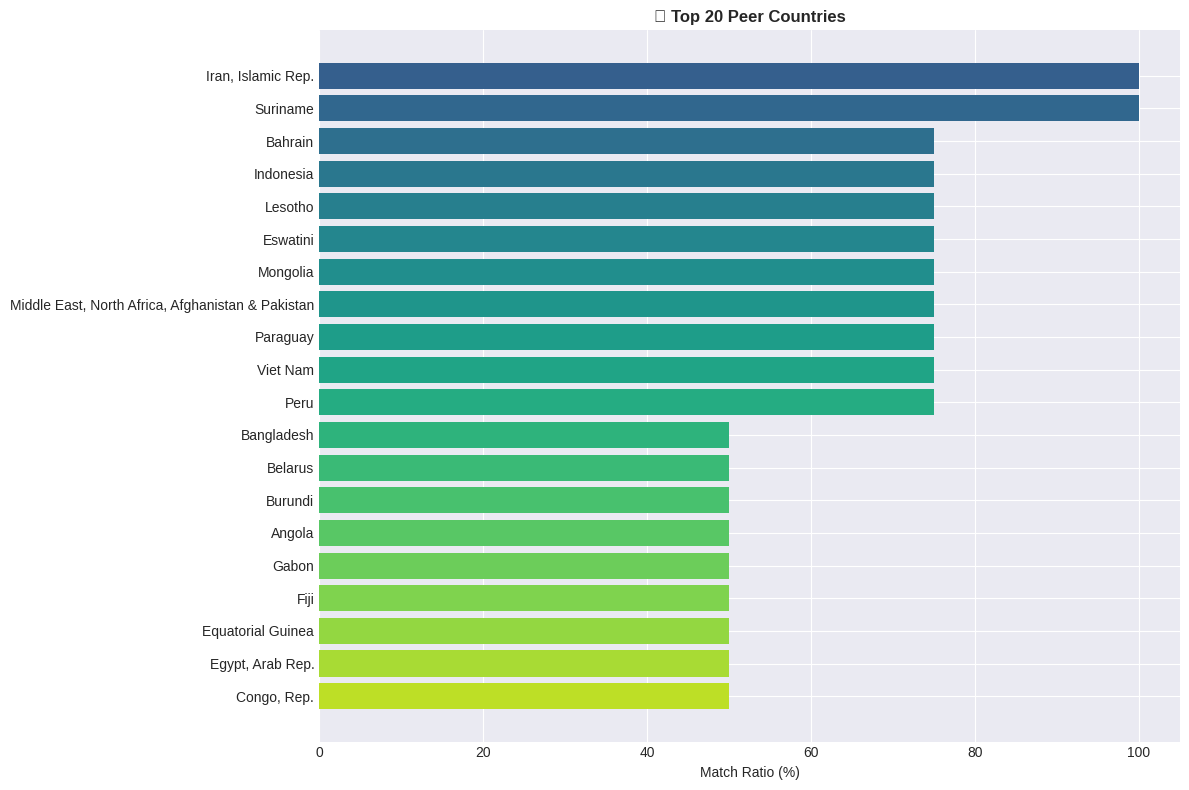

In [65]:
key_indicators = [
    'Gross national income per capita, Atlas method_$_2024',
    'Gross domestic product_% growth_2024',
    'Structure_Value_Industry_% of GDP_2024',
    'Structure_Value_Services_% of GDP_2024'
]
available_key = [col for col in key_indicators if col in df_processed.columns]

peers = []
for idx, row in df_processed.iterrows():
    if row['Country'] == 'Algeria':
        continue
    match_count = sum(1 for col in available_key 
                     if pd.notna(algeria_numeric[col]) and pd.notna(row[col]) 
                     and algeria_numeric[col] != 0
                     and abs((row[col] - algeria_numeric[col]) / algeria_numeric[col]) <= 0.20)
    match_ratio = match_count / len(available_key)
    if match_ratio >= 0.5:
        peers.append({'Country': row['Country'], 'Match_Ratio': match_ratio})

peers_df = pd.DataFrame(peers).sort_values('Match_Ratio', ascending=False)
print(f"\n👥 FOUND {len(peers_df)} PEER COUNTRIES:")
print(peers_df.head(15).to_string(index=False))

if len(peers_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = peers_df.head(20)
    ax.barh(range(len(top_20)), top_20['Match_Ratio']*100, 
            color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20))))
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Country'], fontsize=10)
    ax.set_xlabel('Match Ratio (%)')
    ax.set_title('👥 Top 20 Peer Countries', fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()

# TECHNIQUE 6: CORRELATION-BASED SIMILARITY


🔗 TOP 15 HIGHEST CORRELATION:
           Country  Correlation
           Hungary     0.999175
             Chile     0.997759
      Saudi Arabia     0.997004
           Morocco     0.996738
           Czechia     0.996404
              Peru     0.996158
     Cote d'Ivoire     0.995438
          Colombia     0.994563
         Singapore     0.994408
   Slovak Republic     0.994178
        Bangladesh     0.993666
             Libya     0.993012
           Turkiye     0.992485
           Austria     0.992307
Iran, Islamic Rep.     0.991195


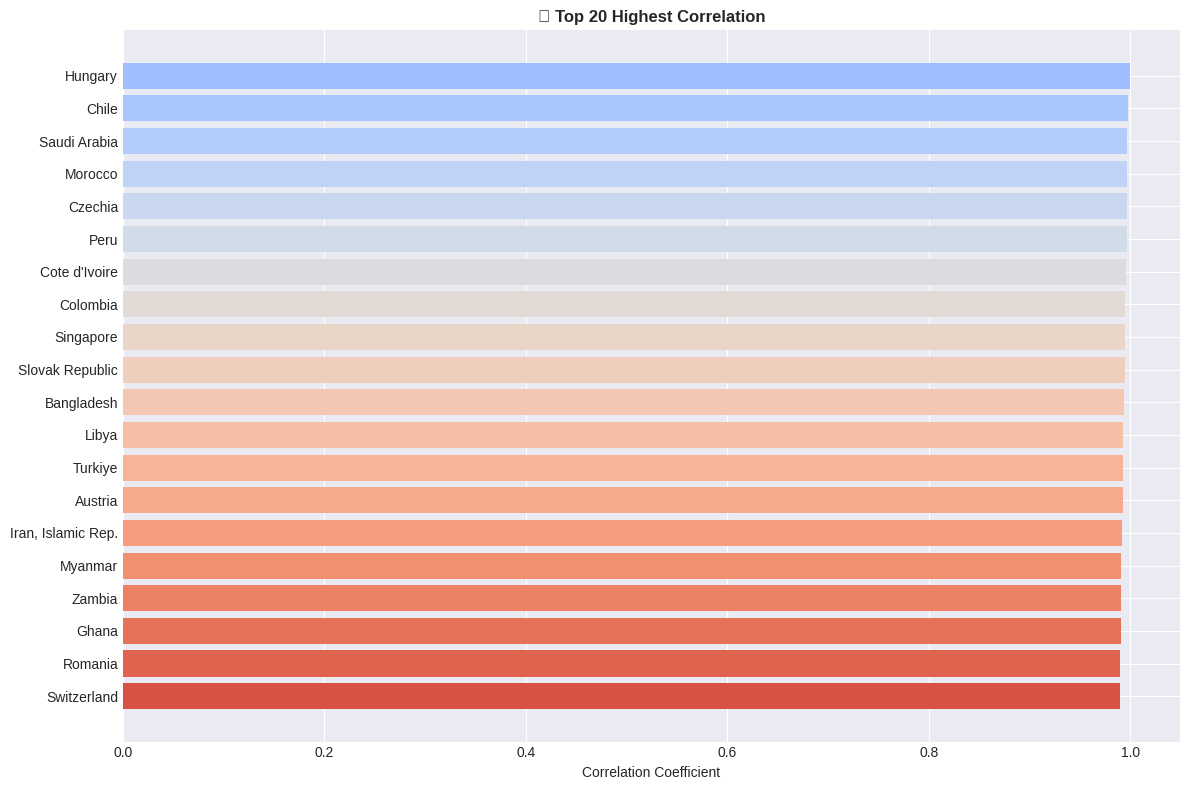

In [72]:
correlations = {}
for idx, row in df_processed.iterrows():
    if row['Country'] != 'Algeria':
        country_numeric = row.drop('Country')
        valid = ~(algeria_numeric.isna() | country_numeric.isna())
        if valid.sum() > 10:
            # Convert to numpy arrays and ensure they're numeric (float64)
            algeria_vals = algeria_numeric[valid].astype(float).values.flatten()
            country_vals = country_numeric[valid].astype(float).values.flatten()
            
            # Use scipy's pearsonr
            from scipy.stats import pearsonr
            corr_value, _ = pearsonr(algeria_vals, country_vals)
            correlations[row['Country']] = corr_value

corr_df = pd.DataFrame(list(correlations.items()), 
                       columns=['Country', 'Correlation']).sort_values('Correlation', ascending=False)

print(f"\n🔗 TOP 15 HIGHEST CORRELATION:")
print(corr_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
top_20 = corr_df.head(20)
ax.barh(range(len(top_20)), top_20['Correlation'], 
        color=plt.cm.coolwarm(np.linspace(0.3, 0.9, 20)))
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Country'], fontsize=10)
ax.set_xlabel('Correlation Coefficient')
ax.set_title('🔗 Top 20 Highest Correlation', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()

# TECHNIQUE 7: TOPSIS ANALYSIS


🏅 TOP 15 BY TOPSIS SCORE:
                 Country  TOPSIS_Score
                  Guyana      0.762090
Northern Mariana Islands      0.536559
        Macao SAR, China      0.486371
              San Marino      0.479977
                 Bermuda      0.471850
                 Georgia      0.456006
                   Samoa      0.450675
         Kyrgyz Republic      0.449849
                  Norway      0.448116
               Singapore      0.447816
                   Qatar      0.447083
                  Rwanda      0.446088
              Tajikistan      0.445800
                 Denmark      0.439483
                   Niger      0.439408

🇩🇿 ALGERIA RANK: 3/266


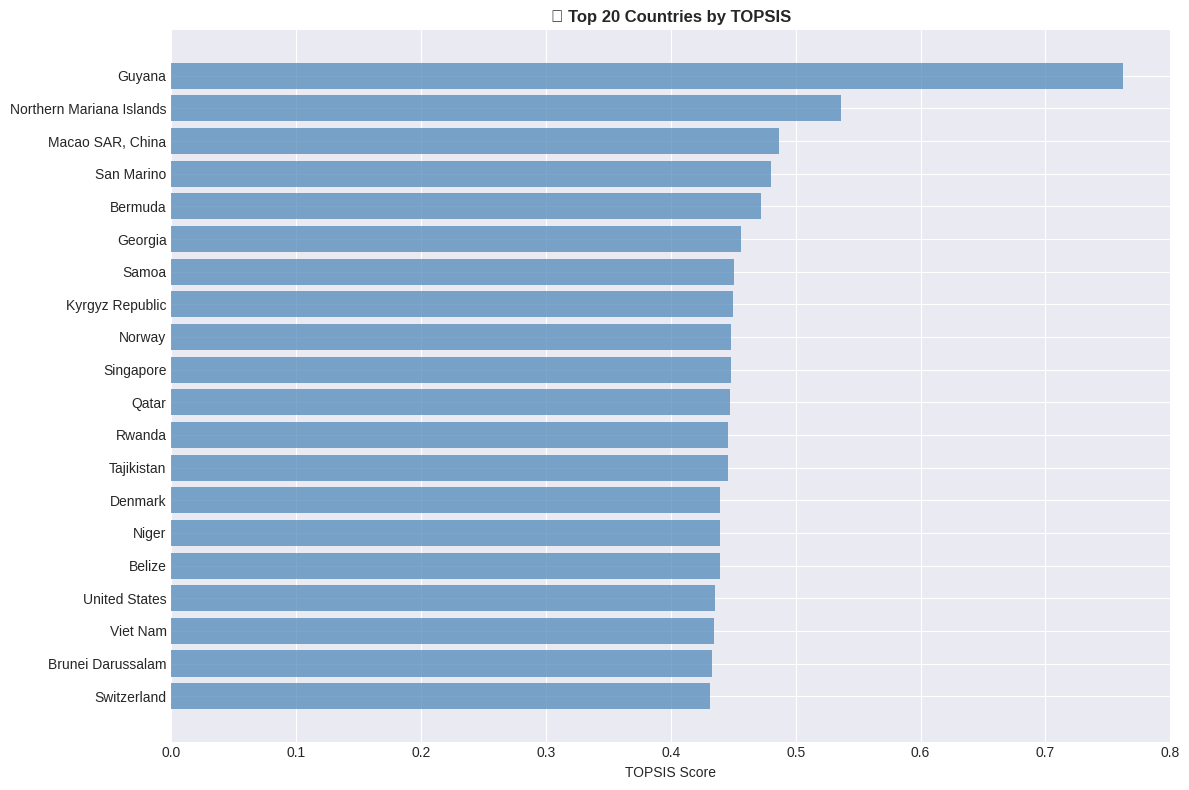

In [67]:
topsis_indicators = ['Gross national income per capita, Atlas method_$_2024',
                     'Gross domestic product_% growth_2024',
                     'Structure_Value_Industry_% of GDP_2024']
available_topsis = [col for col in topsis_indicators if col in df_processed.columns]

topsis_data = df_processed[['Country'] + available_topsis].fillna(
    df_processed[available_topsis].median())
normalized = topsis_data[available_topsis].values / np.sqrt(
    (topsis_data[available_topsis].values**2).sum(axis=0))

ideal_best = normalized.max(axis=0)
ideal_worst = normalized.min(axis=0)
distance_to_best = np.sqrt(((normalized - ideal_best)**2).sum(axis=1))
distance_to_worst = np.sqrt(((normalized - ideal_worst)**2).sum(axis=1))
topsis_score = distance_to_worst / (distance_to_best + distance_to_worst)

topsis_results = pd.DataFrame({
    'Country': topsis_data['Country'],
    'TOPSIS_Score': topsis_score
}).sort_values('TOPSIS_Score', ascending=False)

print(f"\n🏅 TOP 15 BY TOPSIS SCORE:")
print(topsis_results.head(15).to_string(index=False))

algeria_rank = topsis_results[topsis_results['Country'] == 'Algeria'].index[0] + 1
print(f"\n🇩🇿 ALGERIA RANK: {algeria_rank}/{len(topsis_results)}")

fig, ax = plt.subplots(figsize=(12, 8))
top_20 = topsis_results.head(20)
colors = ['red' if c == 'Algeria' else 'steelblue' for c in top_20['Country']]
ax.barh(range(len(top_20)), top_20['TOPSIS_Score'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Country'], fontsize=10)
ax.set_xlabel('TOPSIS Score')
ax.set_title('🏅 Top 20 Countries by TOPSIS', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()